# Brain Segmentation - Utilizando o modelo Unet com Pytorch

Participantes (RA e nome)

- Jimi Togni - RA 226359

- Joany Rodrigues - RA 264440

- Victor Praxedes Rael - RA 240242


Este notebook trata da segmentação e detecção de imagens do cerebro, usando o modelo U-net, utiliazando imagens de MRI ponderada em T1 como entrada. Utilizamos o framework PyTorch junto com o MONAI (Medical Open Network for AI) para desenvolver o projeto.

MONAI é uma estrutura baseada em PyTorch de código aberto para desenvolver algoritmos DL/ML, especificamente para imagens médicas, ele fornece ferramentas e utilitários para pré-processamento, aumento de dados artificiais, normalização, etc. Também inclui modelos pré-construídos, funções de perda e métricas de avaliação.

In [ ]:
# Importing libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nibabel as nib
import scipy.ndimage as ndimage

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import monai
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, DiceCELoss
from monai.data import Dataset, ArrayDataset, DataLoader
from monai.data.utils import default_collate, pad_list_data_collate
from monai.transforms import (LoadImaged, EnsureChannelFirstd, ScaleIntensityd, RandCropByPosNegLabeld, RandAxisFlipd, Resized,\
                             RandGaussianNoised, RandGibbsNoised, RandSpatialCropd, DivisiblePadd, Transposed, Compose, ToTensor)

In [ ]:
# paths para as imagens

brain_mri_path = '/content/drive/MyDrive/ia901/projeto_final/dataset/brain/'
binary_mask_path = '/content/drive/MyDrive/ia901/projeto_final/dataset/mask/'

mri_file_path = []
for file in os.listdir(brain_mri_path):
    mri_file_path.append(brain_mri_path + "/" + file)

mask_file_path = []
for file in os.listdir(binary_mask_path):
    mask_file_path.append(binary_mask_path + "/" + file)

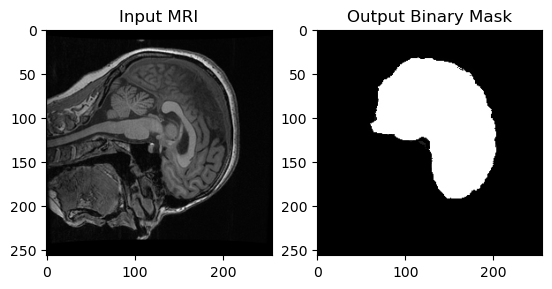

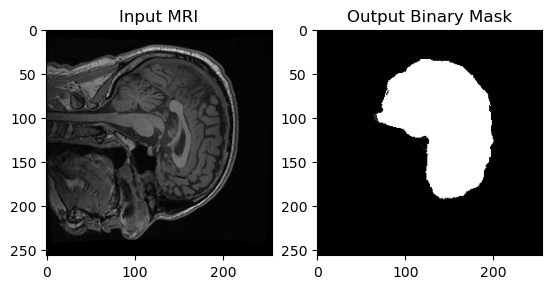

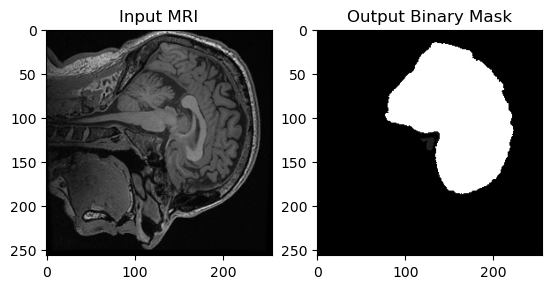

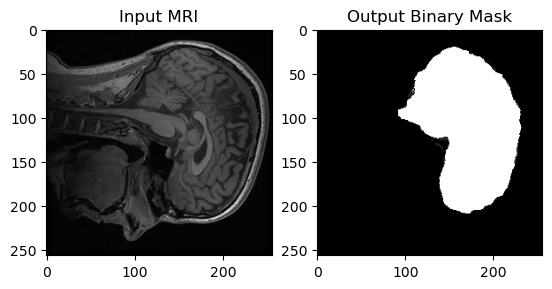

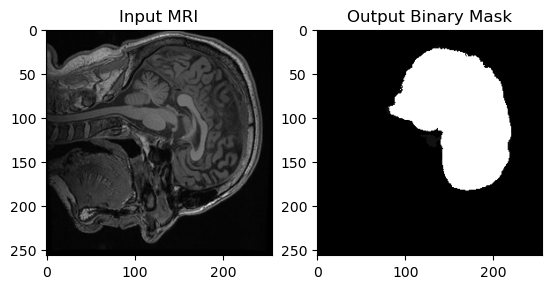

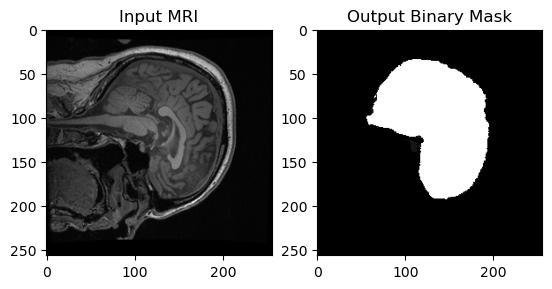

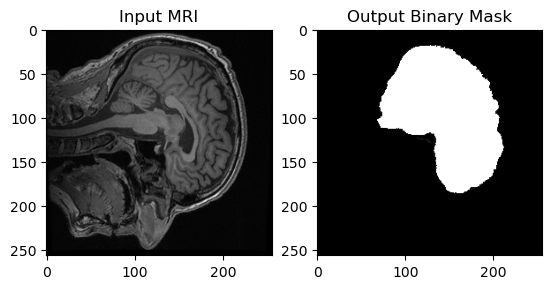

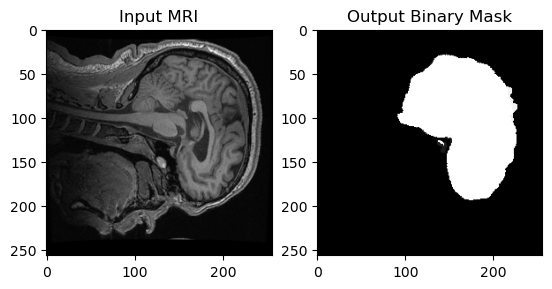

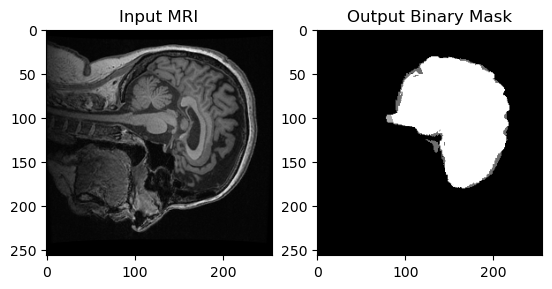

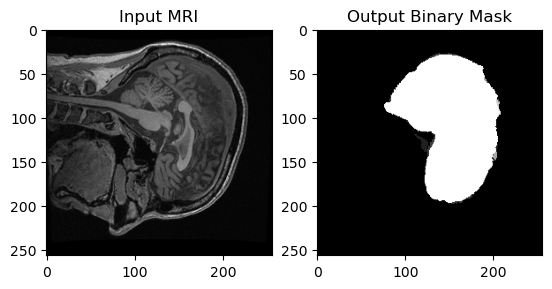

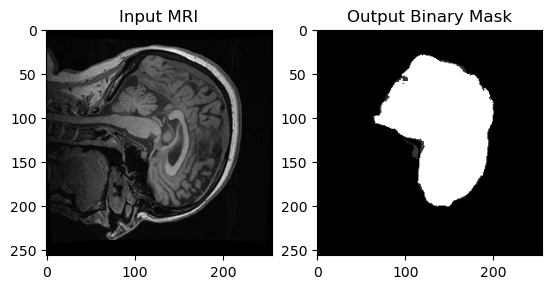

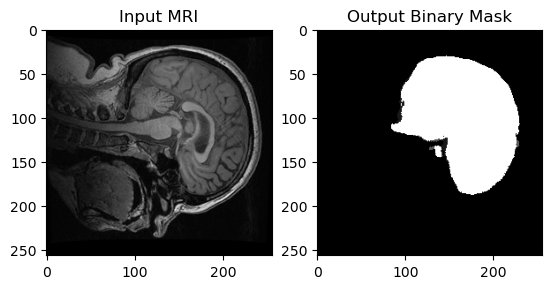

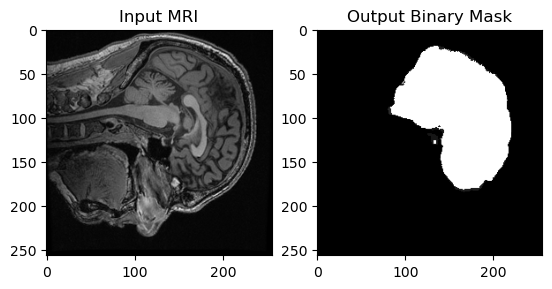

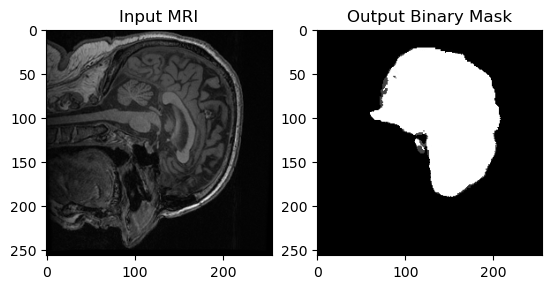

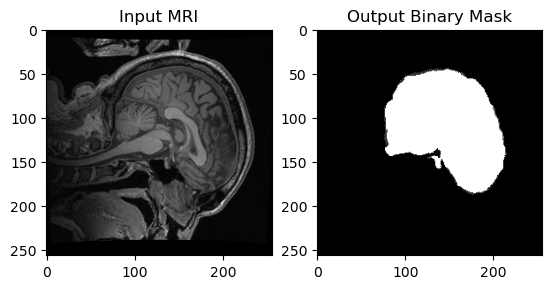

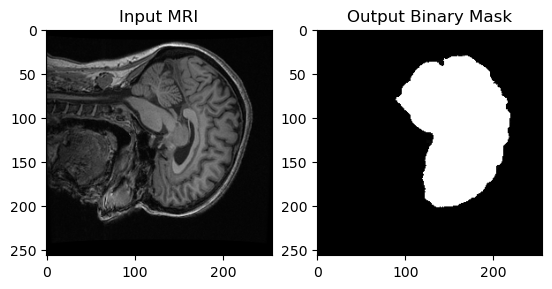

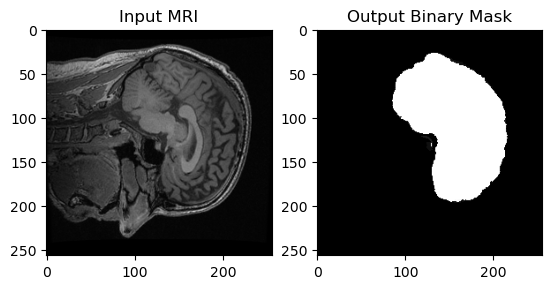

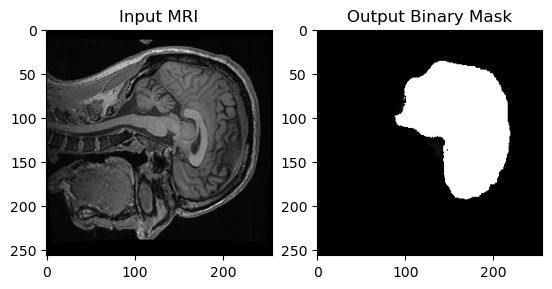

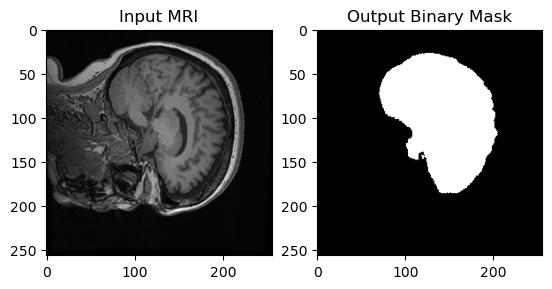

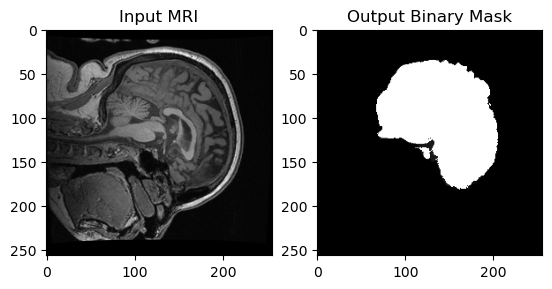

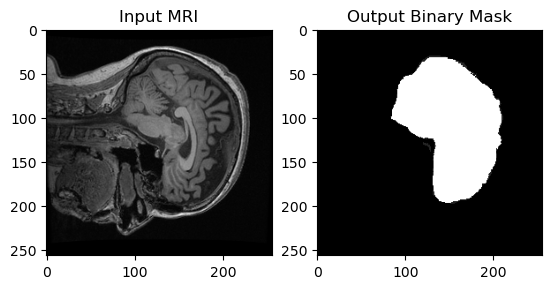

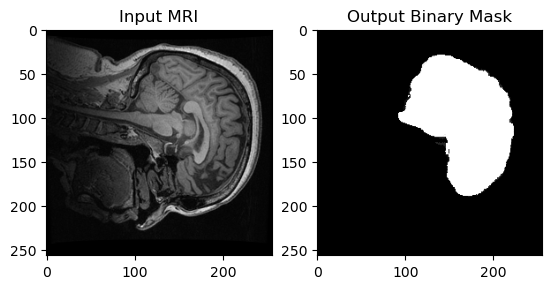

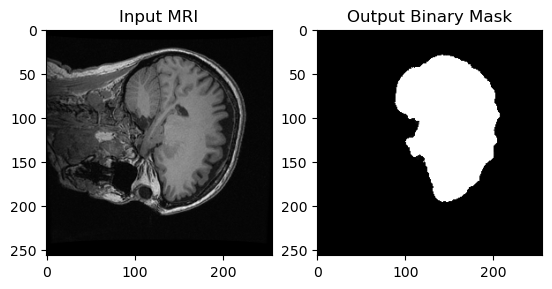

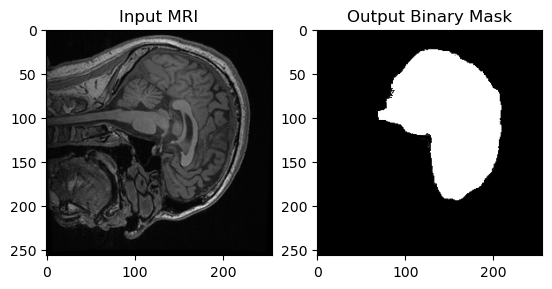

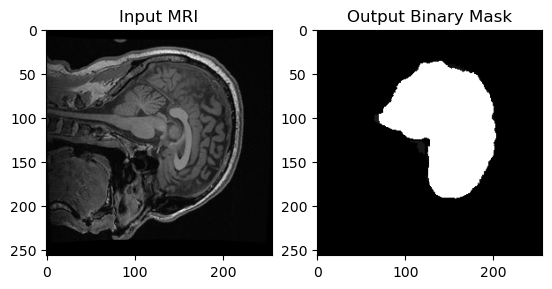

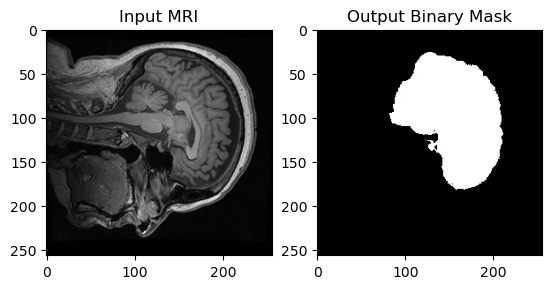

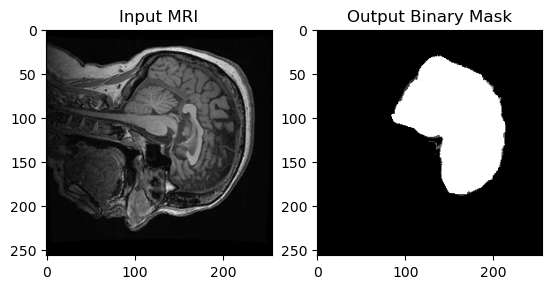

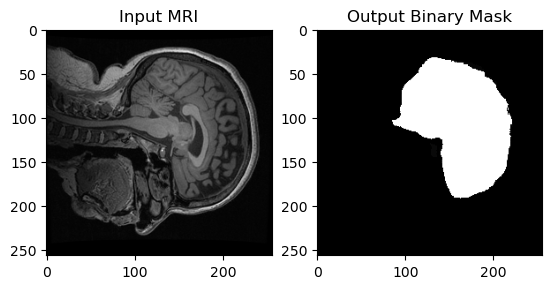

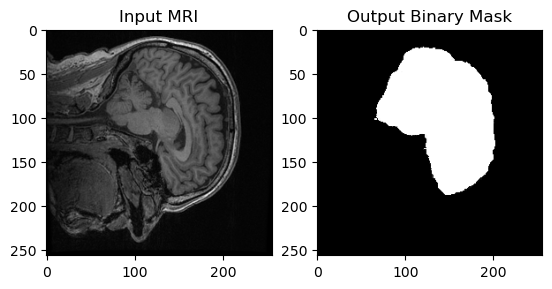

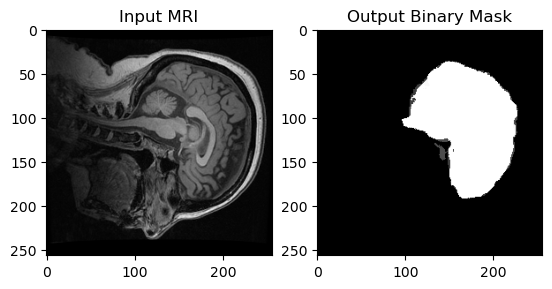

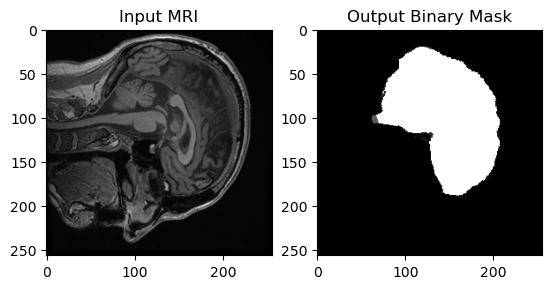

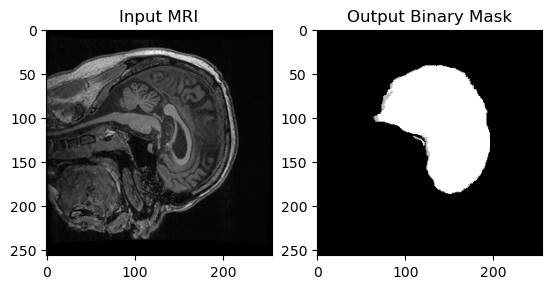

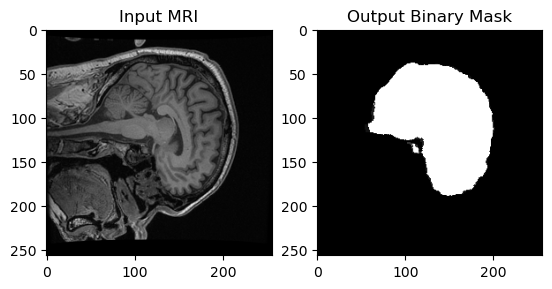

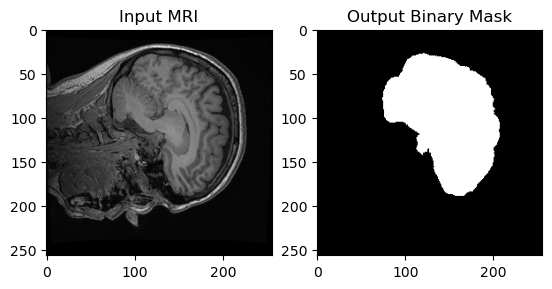

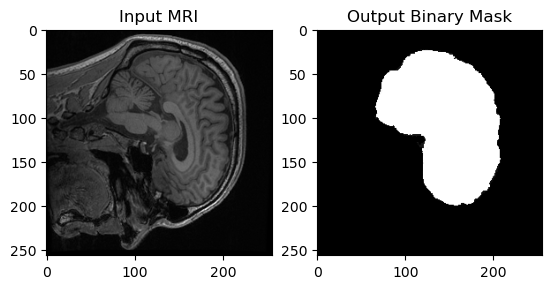

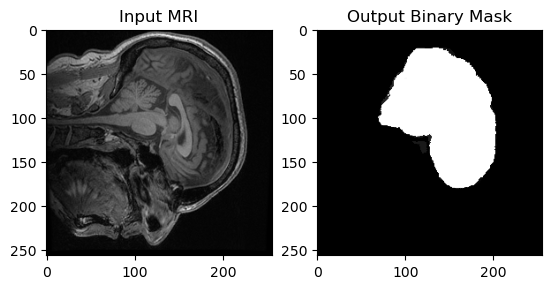

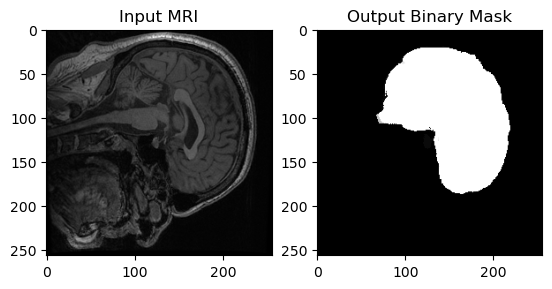

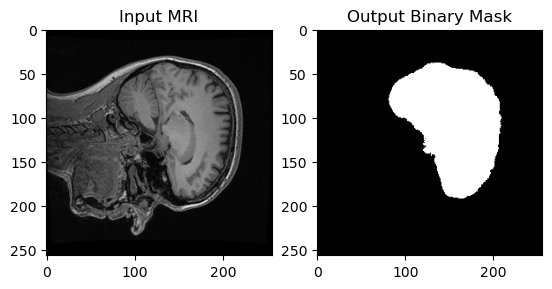

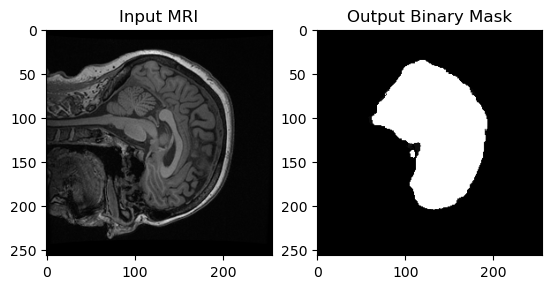

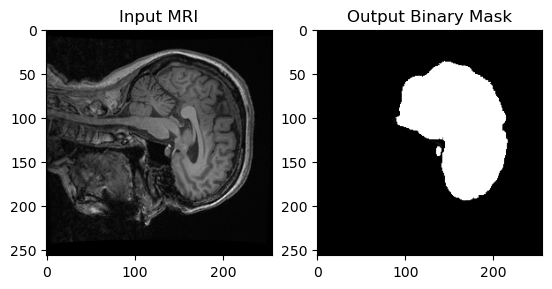

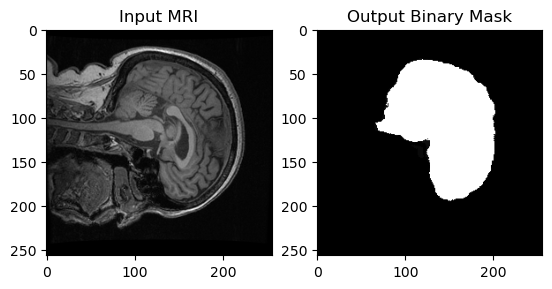

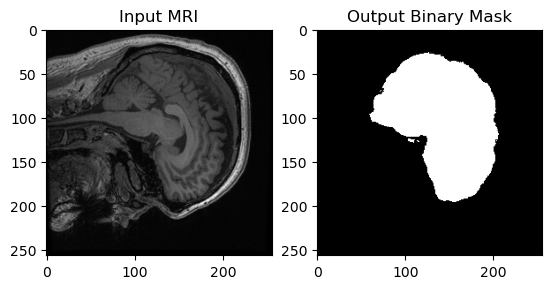

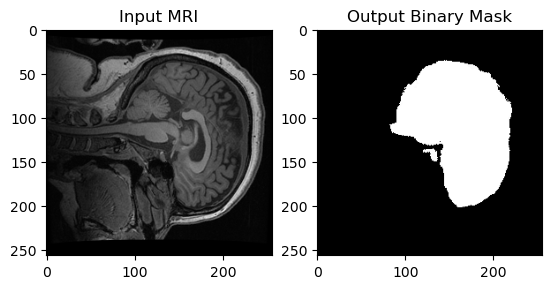

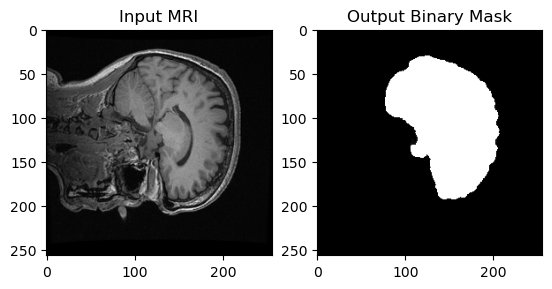

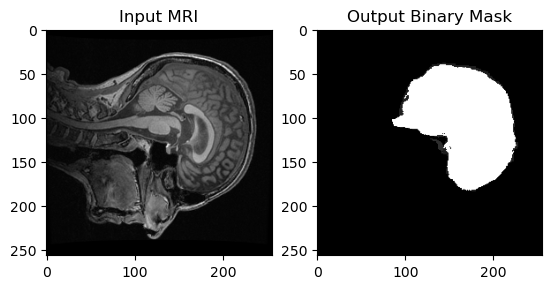

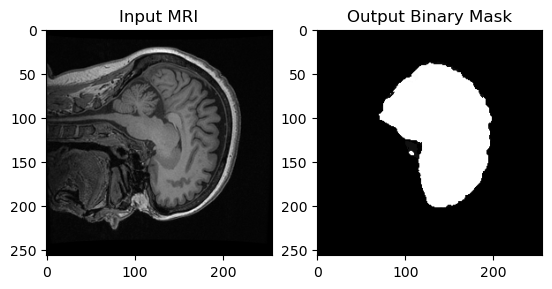

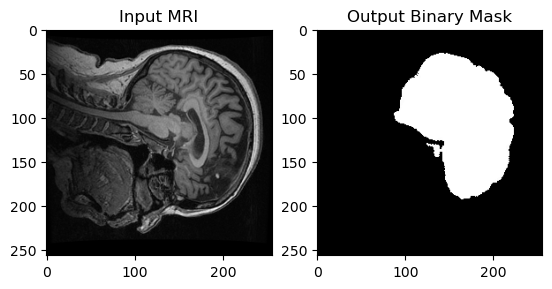

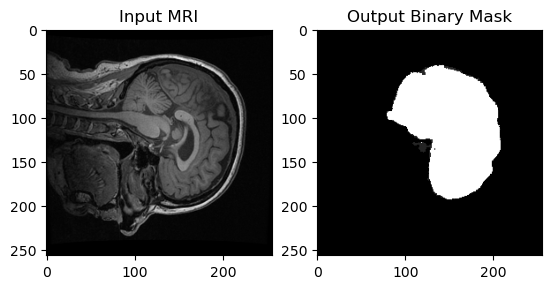

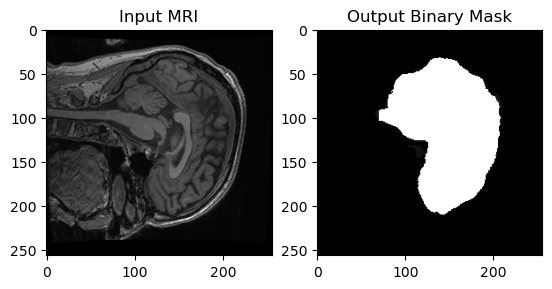

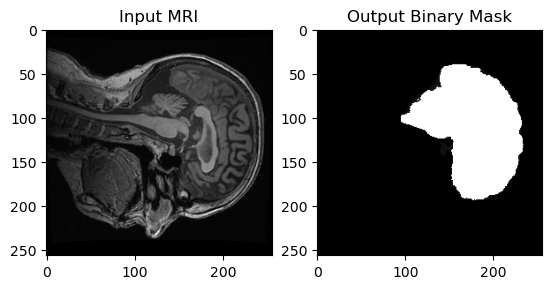

In [ ]:
# Vizualizando os dados e as mascaras

for i in range(0, len(mri_file_path), +1):
    mri = nib.load(mri_file_path[i])
    mask = nib.load(mask_file_path[i])

    mri_data = mri.get_fdata()
    mask_data = mask.get_fdata()

    fig, ax = plt.subplots(1, 2)
    ax[0].set_title("Input MRI")
    ax[0].imshow(mri_data[99, :, :], cmap = "gray")
    ax[1].set_title("Output Binary Mask")
    ax[1].imshow(mask_data[99, :, :], cmap = "gray")
    plt.show()

In [ ]:
# Divisão manual com 80% para treino, 10% validação (rever essa divisão), teste 10%

train_mri_file_path = mri_file_path[0:40]
train_mask_file_path = mask_file_path[0:40]

val_mri_file_path = mri_file_path[40:45]
val_mask_file_path = mask_file_path[40:45]

test_mri_file_path = mri_file_path[45:50]
test_mask_file_path = mask_file_path[45:50]

# Preprocessing using MONAI Transforms - Creating MONAI DataLoader

*   Item da lista
*   Item da lista



In [ ]:
# Creating dictionary (KEY-VALUE pair) for Training, Validation and Testing data

train_filepath_dict = [{"mri": x, "mask": y} for (x,y) in zip(train_mri_file_path, train_mask_file_path)]
val_filepath_dict = [{"mri": x, "mask": y} for (x,y) in zip(val_mri_file_path, val_mask_file_path)]
test_filepath_dict = [{"mri": x, "mask": y} for (x,y) in zip(test_mri_file_path, test_mask_file_path)]

I used MONAI to transform dictionary to dataset with a few preprocessing steps. In this experiment, I didn't execute data augmentation to observe the performance without having augmented data.

In [ ]:
# pre-processamento e data augmentation

dataset_transforms = Compose(
    [
        LoadImaged(keys = ["mri", "mask"]),  # Loading data from the file path
        EnsureChannelFirstd(keys = ["mri", "mask"]),  # Ensuring a channel at the beginning
        ScaleIntensityd(keys = ["mri"], minv = 0.0, maxv = 1.0),  # Normalizing in a range (0 to 1)
        RandSpatialCropd(keys = ["mri", "mask"], roi_size = (112,112,112), random_size = False),
        RandAxisFlipd(keys = ["mri", "mask"], prob = 0.2),
        RandGaussianNoised(keys = ["mri"], prob = 0.2, mean = 0.0, std = 0.05),
        RandGibbsNoised(keys = ["mri"], prob = 0.2, alpha = (0.1, 0.6))
    ]
)

test_transforms = Compose(
    [
        LoadImaged(keys = ["mri", "mask"]),  # Loading data from the file path
        EnsureChannelFirstd(keys = ["mri", "mask"]),  # Ensuring a channel at the beginning
        ScaleIntensityd(keys = ["mri"], minv = 0.0, maxv = 1.0),  # Normalizing in a range (0 to 1)
        DivisiblePadd(["mri"], 16)
    ]
)

# Creating MONAI Dataset (class) object having specific data pre-processing

train_dataset = monai.data.Dataset(train_filepath_dict, dataset_transforms)
val_dataset = monai.data.Dataset(val_filepath_dict, dataset_transforms)
test_dataset = monai.data.Dataset(test_filepath_dict, test_transforms)

In [ ]:
# Creating dataloader along with initializing batch size

train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True, num_workers=0, pin_memory=True, collate_fn=pad_list_data_collate)
val_dataloader = DataLoader(val_dataset, batch_size = 8, shuffle = True, num_workers=0, pin_memory=True, collate_fn=pad_list_data_collate)
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = False, num_workers = 0, pin_memory = True, collate_fn = pad_list_data_collate)

In [ ]:
# Printing each batch and its tensors size for training dataset

print("Training Data Shape\n")
for batch_idx, batch_data in enumerate(train_dataloader):
    inputs, labels = batch_data["mri"], batch_data["mask"]
    print(f"Batch {batch_idx}:")
    print(f"Input MRI shape: {inputs.shape}")
    print(f"Output Mask shape: {labels.shape}")

Training Data Shape

Batch 0:
Input MRI shape: torch.Size([8, 1, 112, 112, 112])
Output Mask shape: torch.Size([8, 1, 112, 112, 112])
Batch 1:
Input MRI shape: torch.Size([8, 1, 112, 112, 112])
Output Mask shape: torch.Size([8, 1, 112, 112, 112])
Batch 2:
Input MRI shape: torch.Size([8, 1, 112, 112, 112])
Output Mask shape: torch.Size([8, 1, 112, 112, 112])
Batch 3:
Input MRI shape: torch.Size([8, 1, 112, 112, 112])
Output Mask shape: torch.Size([8, 1, 112, 112, 112])
Batch 4:
Input MRI shape: torch.Size([8, 1, 112, 112, 112])
Output Mask shape: torch.Size([8, 1, 112, 112, 112])


In [ ]:
# Printing each batch and its tensors size for validation dataset

print("Validation Data Shape\n")
for batch_idx, batch_data in enumerate(val_dataloader):
    inputs, labels = batch_data["mri"], batch_data["mask"]
    print(f"Batch {batch_idx}:")
    print(f"Input MRI shape: {inputs.shape}")
    print(f"Output Mask shape: {labels.shape}")

Validation Data Shape

Batch 0:
Input MRI shape: torch.Size([5, 1, 112, 112, 112])
Output Mask shape: torch.Size([5, 1, 112, 112, 112])


In [ ]:
# Printing each batch and its tensors size for test dataset

print("Testing Data Shape\n")
for batch_idx, batch_data in enumerate(test_dataloader):
    inputs= batch_data["mri"]
    print(f"Batch {batch_idx}:")
    print(f"Input MRI shape: {inputs.shape}")

Testing Data Shape

Batch 0:
Input MRI shape: torch.Size([1, 1, 192, 256, 256])
Batch 1:
Input MRI shape: torch.Size([1, 1, 208, 256, 256])
Batch 2:
Input MRI shape: torch.Size([1, 1, 208, 256, 256])
Batch 3:
Input MRI shape: torch.Size([1, 1, 208, 256, 256])
Batch 4:
Input MRI shape: torch.Size([1, 1, 208, 256, 256])


# U-Net Architecture

O modelo U-net contém quatro camadas Conv de downsampling (parte de codificação), com quatro camadas de pooling e uma camada de Bottleneck, seguida por quatro camadas de upsampling Conv na parte 2 do projeto.

Uma camada de Transposição foi adicionada antes do Upsampling para aumentar a resolução espacial. Cada Codificador/Decodificador consiste em uma camada conv dupla tendo uma sequência de camadas Conv>BatchNorm>Relu>Conv>BatchNorm>Relu.

Na camada final, a saída foi passada pela função sigmóide para obter valores de probabilidade para cada voxel e limite para obter resultados binários.

In [ ]:
class conv_block(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()

        self.conv1 = nn.Conv3d(input_channels, output_channels, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm3d(output_channels)

        self.conv2 = nn.Conv3d(output_channels, output_channels, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm3d(output_channels)

        self.relu = nn.ReLU()

    def forward(self, input_image):
        x = self.conv1(input_image)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x


class encoder_block(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()

        self.conv = conv_block(input_channels, output_channels)
        self.pool = nn.MaxPool3d((2,2,2))

    def forward(self, input_image):
        x = self.conv(input_image)
        p = self.pool(x)

        return x, p


class decoder_block(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()

        self.up = nn.ConvTranspose3d(input_channels, output_channels, kernel_size = 2, stride = 2, padding = 0)
        self.conv = conv_block(output_channels+output_channels, output_channels)

    def forward(self, input_image, skip):
        x = self.up(input_image)
        x = torch.cat([x, skip], axis = 1)
        x = self.conv(x)

        return x


class Unet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoding Part
        self.e1 = encoder_block(1, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        # Bottleneck Part
        self.b = conv_block(512, 1024)

        # Decoding Part
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        # Classification Part
        self.outputs = nn.Conv3d(64, 2, kernel_size = 1, padding = 0)


    def forward(self, input_image):
        # Calling Encoder
        s1, p1 = self.e1(input_image)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        # Calling Bottleneck
        b = self.b(p4)

        # Calling Decoder
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        # Calling Classifier
        output = self.outputs(d4)
        output = torch.softmax(output, dim = 1)

        return output


model = Unet()

# Treino e Validação

In [ ]:
# Inicializar o DiceLoss to para minimizar o loss.
# para single channel prediction: to_onehot_y=False, para double channel prediction: to_onehot_y=True
loss_object = DiceLoss(to_onehot_y = True)

# Adam optimizer com learning rate = 0.001 and weight_decay = 0.0001.
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 1e-4)

n_epochs = 20

for epoch in range(n_epochs):
    train_loss = 0.0
    val_loss = 0.0

    model.train()
    for train_batch_idx, train_batch_data in enumerate(train_dataloader):
        input_mri, actual_mask = train_batch_data["mri"], train_batch_data["mask"]

        optimizer.zero_grad()
        predicted_mask = model(input_mri)
        loss = loss_object(predicted_mask, actual_mask)
        loss.backward()
        train_loss = train_loss + loss.item()
        optimizer.step()

    train_loss = train_loss / (train_batch_idx + 1)


    # evaluate on validation set
    model.eval()
    with torch.no_grad():
        for val_batch_idx, val_batch_data in enumerate(val_dataloader):
            val_input_mri, val_actual_mask = val_batch_data["mri"], val_batch_data["mask"]

            val_predicted_mask = model(val_input_mri)
            loss = loss_object(val_predicted_mask, val_actual_mask)
            val_loss = val_loss + loss.item()

        val_loss = val_loss / (val_batch_idx + 1)

    print('Epoch: {} \tAvg Training Loss: {:.6f} \tAvg Validation Loss: {:.6f}'.format(epoch+1, train_loss, val_loss))

Epoch: 1 	Avg Training Loss: 0.341632 	Avg Validation Loss: 0.729602
Epoch: 2 	Avg Training Loss: 0.218388 	Avg Validation Loss: 0.744803
Epoch: 3 	Avg Training Loss: 0.223649 	Avg Validation Loss: 0.509445
Epoch: 4 	Avg Training Loss: 0.155669 	Avg Validation Loss: 0.629837
Epoch: 5 	Avg Training Loss: 0.187160 	Avg Validation Loss: 0.549561
Epoch: 6 	Avg Training Loss: 0.172256 	Avg Validation Loss: 0.692493
Epoch: 7 	Avg Training Loss: 0.144027 	Avg Validation Loss: 0.574883
Epoch: 8 	Avg Training Loss: 0.138380 	Avg Validation Loss: 0.144210
Epoch: 9 	Avg Training Loss: 0.091882 	Avg Validation Loss: 0.127831
Epoch: 10 	Avg Training Loss: 0.069162 	Avg Validation Loss: 0.058944
Epoch: 11 	Avg Training Loss: 0.137738 	Avg Validation Loss: 0.216473
Epoch: 12 	Avg Training Loss: 0.090519 	Avg Validation Loss: 0.169023
Epoch: 13 	Avg Training Loss: 0.115983 	Avg Validation Loss: 0.048739
Epoch: 14 	Avg Training Loss: 0.100926 	Avg Validation Loss: 0.190688
Epoch: 15 	Avg Training Loss:

In [ ]:
# torch.save(model.state_dict(), "trained_Unet_model_v3.pt")
# model.load_state_dict(torch.load("trained_Unet_model_v3.pt"))
# model.eval()

# Testando o modelo

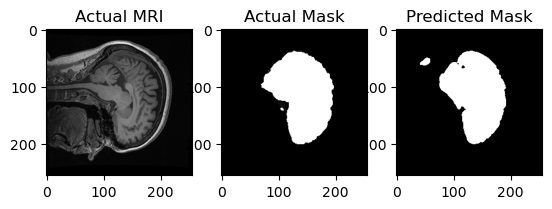

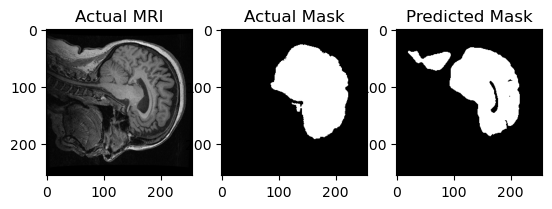

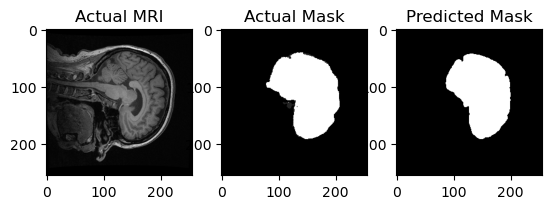

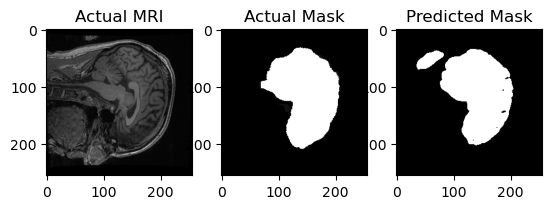

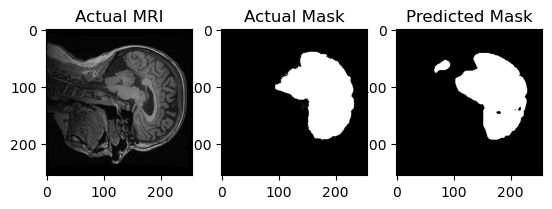

In [ ]:
for test_batch_idx, test_batch_data in enumerate (test_dataloader):
    test_input_mri, test_actual_mask = test_batch_data["mri"], test_batch_data["mask"]

    test_predicted_mask = model(test_input_mri)
    test_predicted_mask = torch.argmax(test_predicted_mask, dim=1).cpu().numpy()[0]

    fig, axs = plt.subplots(1, 3)
    axs[0].set_title('Actual MRI')
    axs[0].imshow(test_input_mri[0, 0, 99, :, :], cmap = "gray")
    axs[1].set_title('Actual Mask')
    axs[1].imshow(test_actual_mask[0, 0, 99, :, :], cmap = "gray")
    axs[2].set_title('Predicted Mask')
    axs[2].imshow(test_predicted_mask[99, :, :], cmap = "gray")
    plt.show()

Próximos passos:
- aumentar o numero de épocas
- otimizar uso de memória RAM
- inserir os outros datasets
- implementar pre-processamento nas imagens